# Fichier pour prérarer les données pour les TP 2 et 3

Basé sur le travail du TP1. Produit les 4 TBA suivants:
- customers_bin_avec_gdp.csv: TBA avec revenu labellisé binaire et colonne gdp
- customers_bin_sans_gdp.csv: TBA avec revenu labellisé binaire
- customers_cat_avec_gdp.csv: TBA avec revenu labellisé en 3 catégories et colonne gdp
- customers_cat_sans_gdp.csv: TBA avec revenu labellisé en 3 catégories

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from IPython import InteractiveShell
from sklearn.compose import *
from sklearn.feature_extraction.text import _VectorizerMixin
from sklearn.feature_selection._base import SelectorMixin
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import *
InteractiveShell.ast_node_interactivity = "all"

# Initialise la grosseur de figures
plt.rcParams["figure.figsize"] = (20,10)

# Récupérer les données

In [2]:
customers = pd.read_csv('Customer.csv', na_values=['?', 'unknown'])
gdps = pd.read_csv('CountryGDP.csv')
populations = pd.read_csv('CountryPopulation.csv')

## Création des jeux de données d'entrainement et de test

In [3]:
train_set, test_set = train_test_split(customers, test_size=0.2, random_state=42)
train_set.shape
test_set.shape

(8000, 8)

(2000, 8)

### Remplacement des données aberrantes

In [4]:
# Création de la fonctionn qui sera appellée dans le pipeline
def fit_outliers(df: pd.DataFrame) -> pd.DataFrame:
    '''
    Fonction pour le 'clamp transformation'.
    Ramène tout les outliers (hors de [Q1 - 1.5IQR, Q3 + 1.5IQR] à l'intérieur de l'interval.
    :param df:
    :return:
    '''
    cols = df.columns
    Q1 = df[cols].quantile(0.25)
    Q3 = df[cols].quantile(0.75)
    IQR = Q3 - Q1

    q15 = (Q1 - 1.5 * IQR)
    q35 = (Q3 + 1.5 * IQR)
    df2 = df[cols].clip(q15[cols], q35[cols], axis=1)

    return df2

<AxesSubplot:>

,first_item_prize,age
count,7997.000000,8000.000000
mean,40.285044,37.391750
std,27.625504,9.480534
min,10.000000,18.000000
25%,22.000000,31.000000
50%,42.000000,37.000000
75%,44.000000,43.000000
max,117.000000,79.000000


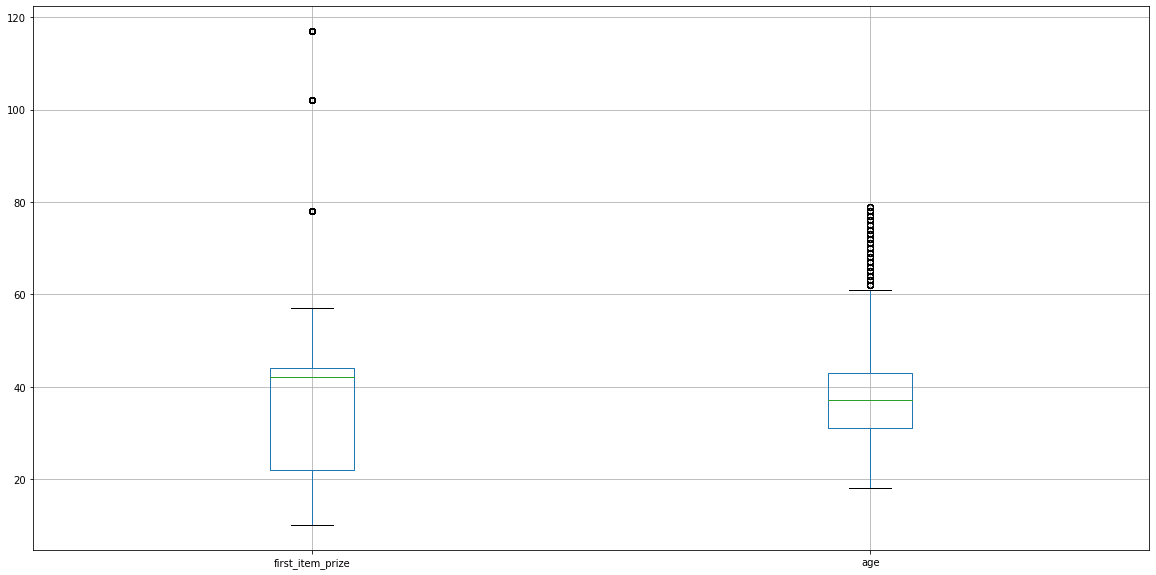

In [5]:
# Test de la fonction clip
dftest = train_set[['first_item_prize', 'age']].copy()
dftest.boxplot()
dftest.describe()

<AxesSubplot:>

,first_item_prize,age
count,7997.000000,8000.00000
mean,37.206140,37.18925
std,20.747153,8.82027
min,10.000000,18.00000
25%,22.000000,31.00000
50%,42.000000,37.00000
75%,44.000000,43.00000
max,77.000000,61.00000


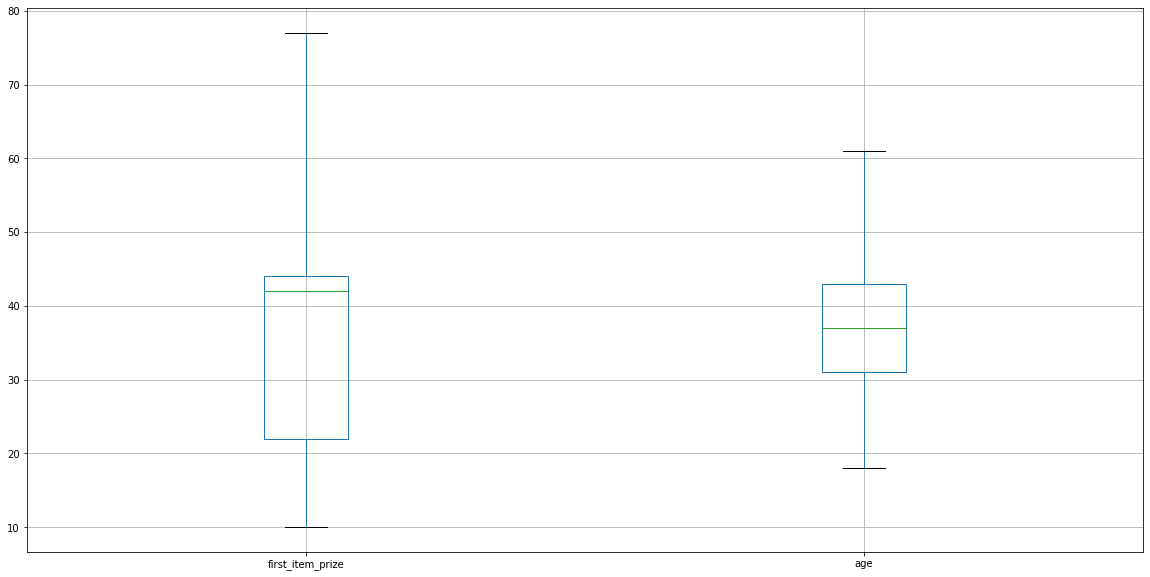

In [6]:
# Execute et check le résultat
ret = fit_outliers(dftest)
ret.boxplot()
ret.describe()
del dftest
del ret
# La fonction fit_outliers semble bien fonctionner.

In [7]:
def clamp_transformation(data):
    '''
    # Version pour nparray (le pipeline fonctionnne avec des arrays
    # Convertie en DataFrame pour appeler fit_outliers
    '''
    return fit_outliers(pd.DataFrame(data))


### Fonction pour joindre les datasets CountryPopulation et CountryGDP

In [8]:
def merge_country_data(data: pd.DataFrame, pop_data: pd.DataFrame = None,
                       gdp_data: pd.DataFrame = None) -> pd.DataFrame:
    """
    Merge les données de population et/ou de gdp par habitant au dataset customer
    :param data: DataFrame customers d'origine (assume une colonne nommée 'country')
    :param pop_data: Optionel. DataFrame population à joindre (assume une colonne nommée 'Country')
    :param gdp_data: Optionel. DataFrame gdpData à joindre (assume une colonne nommée 'Country')
    :return: Un nouveau DataFrame
    """
    new_data = data.copy()
    if pop_data is not None:
        new_data = new_data.merge(pop_data.rename(columns={'Country': 'country'}))
    if gdp_data is not None:
        new_data = new_data.merge(gdp_data.rename(columns={'Country': 'country'}))
    return new_data

In [9]:
def merge_data(data, include_gdps=False):
    '''
    Pour faire comme demandé dans TP.
    Fonction qui sera utilisée dans le pipeline. Merge population automatiquement.

    :param data:
    :param include_gdps: Si include_gdps True, merge gdps aussi
    :return: dataframe modifié
    '''
    print('include_gdps={}'.format(include_gdps))
    if include_gdps:
        print('merge avec gdps')
        return merge_country_data(data, populations, gdps)
    print('merge sans gdps')
    return merge_country_data(data, populations)

In [10]:
# TP2 - Question 2.1.1 - Fonction pour remplacer revenu par une valeur binaire
def binary_label_encoder(X):
    med = np.nanmedian(X)
    print('median={}'.format(med))
    X=np.where(X < med, False, True)
    return X

dftest = train_set["revenue"].copy()
Binary_Func = FunctionTransformer(binary_label_encoder)
ret = Binary_Func.fit_transform(dftest)
del dftest
del ret

median=100.0


In [11]:
# TP2 - Question 2.2.1 - Fonction pour remplacer revenu par 3 catégories
def category_label_encoder(X):
    moy = np.mean(X)
    std = np.std(X)
    bas = moy - (1 * std)
    haut = moy + (1 * std)

    print (moy, std)
    conditions  = [X < bas, (X >= bas) & (X <= haut), X > haut]
#    choices     = ['bas', 'moyen', 'haut']
    choices     = [0, 1, 2]

    X = np.select(conditions, choices, default=np.nan)

    return X

dftest = train_set["revenue"].copy()
Cat_Func = FunctionTransformer(category_label_encoder)
ret = Cat_Func.fit_transform(dftest)
print(pd.DataFrame(ret).value_counts())
#del dftest #permet de libérer la mémoire du notebook de la variable temporaire.
#del ret

122.72527197699137 86.43890940840272
1.0    6027
2.0    1200
0.0     770
dtype: int64


In [12]:
def label_encoder(X, binary=True):
    """Fonction qui choisit entre binary encoder et categorical encoder"""
    if binary:
        return binary_label_encoder(X)
    else:
        return category_label_encoder(X)


## Création du pipeline

In [13]:
# Transformation des variables numériques
num_transformer = Pipeline([
    ('imputer', SimpleImputer()),
    # Question 3.1.2: Remplacement des données aberrantes
    ('clamp', FunctionTransformer(clamp_transformation, validate=False)),#clamp transformation = fonction pour retourner en dataframe
    ('std', StandardScaler())
], verbose=False)


In [14]:
# Transformation des variables catégorielles
cat_transformer = Pipeline([
    ('encoder', OneHotEncoder(handle_unknown='ignore', sparse=False))
], verbose=False)


In [15]:
# Transformation de labels
label_transformer = Pipeline([
    ('imputer', SimpleImputer()),
    ('power', PowerTransformer(method='box-cox')),
#    ('std', StandardScaler()),
    ('labeler', FunctionTransformer(label_encoder, validate=False))
], verbose=False)


In [16]:
# Prépare toute les données
numCols=['age', 'pages', 'first_item_prize', 'News_click', 'ReBuy']
catCols=['gender', 'country']
preprocessor = ColumnTransformer(
    transformers=[
        ('label', label_transformer, ['revenue']),
        ('num', num_transformer, numCols),
        ('cat', cat_transformer, catCols),
    ],
    remainder='passthrough',
    #remainder indique quoi faire avec les attributs non traités, ou passé dans le preprocessor.
    #Par défaut il les droperait.

    verbose=False,
    #verbose indique quels sont les étapes et où nous sommes rendu.
    #L'ordre a de l'importance dans le transformer, par exemple, la colonne 0 dans ce cas est la colonne de revenue.

)

In [17]:
# On met le tout ensemble
tp1_pipeline = Pipeline([
    # Question 3.2: Fonction pour joindre les datasets CountryPopulation et CountryGDP
    ('merge', FunctionTransformer(merge_data, validate=False)),
    ('preprocessor', preprocessor),
], verbose=False)

In [18]:
### Code pour rebatir un DataFrame après l'execution du pipeline qui transforme en np.array
#Source: https://stackoverflow.com/questions/57528350/can-you-consistently-keep-track-of-column-labels-using-sklearns-transformer-api
def get_feature_out(estimator, feature_in):
    if hasattr(estimator,'get_feature_names'):
        if isinstance(estimator, _VectorizerMixin):
            # handling all vectorizers
            return [f'vec_{f}' \
                for f in estimator.get_feature_names()]
        else:
            return estimator.get_feature_names(feature_in)
    elif isinstance(estimator, SelectorMixin):
        return np.array(feature_in)[estimator.get_support()]
    else:
        return feature_in


def get_ct_feature_names(ct):
    # handles all estimators, pipelines inside ColumnTransfomer
    # doesn't work when remainder =='passthrough'
    # which requires the input column names.
    output_features = []

    for name, estimator, features in ct.transformers_:
        if name!='remainder':
            if isinstance(estimator, Pipeline):
                current_features = features
                for step in estimator:
                    current_features = get_feature_out(step, current_features)
                features_out = current_features
            else:
                features_out = get_feature_out(estimator, features)
            output_features.extend(features_out)
        elif estimator=='passthrough':
            output_features.extend(ct._feature_names_in[features])

    return output_features



Génère un dataset avec customer classé binaire avec GDP pour les TP2 et TP3

In [19]:
# Lancement du pipeline avec gdp pour le train set et test set avec gdp
tp1_pipeline.set_params(merge__kw_args={'include_gdps':True})
label_transformer.set_params(labeler__kw_args={'binary':True})
customers_bin_avec_gdp = pd.DataFrame(tp1_pipeline.fit_transform(customers.copy()), columns=get_ct_feature_names(preprocessor))
customers_bin_avec_gdp.to_csv("customers_bin_avec_gdp.csv", index=False)

Pipeline(steps=[('merge',
                 FunctionTransformer(func=<function merge_data at 0x0000029D839BCEE0>,
                                     kw_args={'include_gdps': True})),
                ('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('label',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('power',
                                                                   PowerTransformer(method='box-cox')),
                                                                  ('labeler',
                                                                   FunctionTransformer(func=<function label_encode...
                                                  ['revenue']),
                                                 ('num',
    

Pipeline(steps=[('imputer', SimpleImputer()),
                ('power', PowerTransformer(method='box-cox')),
                ('labeler',
                 FunctionTransformer(func=<function label_encoder at 0x0000029D83BD7700>,
                                     kw_args={'binary': True}))])

include_gdps=True
merge avec gdps
median=-0.006042344872821809


Génère un dataset avec customer classé binaire avec GDP pour les TP2 et TP3

In [20]:
# Lancement du pipeline avec gdp pour le train set et test set avec gdp
tp1_pipeline.set_params(merge__kw_args={'include_gdps':False})
label_transformer.set_params(labeler__kw_args={'binary':True})
customers_bin_sans_gdp = pd.DataFrame(tp1_pipeline.fit_transform(customers.copy()), columns=get_ct_feature_names(preprocessor))
customers_bin_sans_gdp.to_csv("customers_bin_sans_gdp.csv", index=False)

Pipeline(steps=[('merge',
                 FunctionTransformer(func=<function merge_data at 0x0000029D839BCEE0>,
                                     kw_args={'include_gdps': False})),
                ('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('label',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('power',
                                                                   PowerTransformer(method='box-cox')),
                                                                  ('labeler',
                                                                   FunctionTransformer(func=<function label_encod...
                                                  ['revenue']),
                                                 ('num',
    

Pipeline(steps=[('imputer', SimpleImputer()),
                ('power', PowerTransformer(method='box-cox')),
                ('labeler',
                 FunctionTransformer(func=<function label_encoder at 0x0000029D83BD7700>,
                                     kw_args={'binary': True}))])

include_gdps=False
merge sans gdps
median=-0.006042344872821809


Génère un dataset avec customer classé par catégories avec GDP pour les TP2 et TP3

In [21]:
# Lancement du pipeline avec gdp pour le train set et test set avec gdp
tp1_pipeline.set_params(merge__kw_args={'include_gdps':True})
label_transformer.set_params(labeler__kw_args={'binary':False})
customers_cat_avec_gdp = pd.DataFrame(tp1_pipeline.fit_transform(customers.copy()), columns=get_ct_feature_names(preprocessor))
customers_cat_avec_gdp.to_csv("customers_cat_avec_gdp.csv", index=False)

Pipeline(steps=[('merge',
                 FunctionTransformer(func=<function merge_data at 0x0000029D839BCEE0>,
                                     kw_args={'include_gdps': True})),
                ('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('label',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('power',
                                                                   PowerTransformer(method='box-cox')),
                                                                  ('labeler',
                                                                   FunctionTransformer(func=<function label_encode...
                                                  ['revenue']),
                                                 ('num',
    

Pipeline(steps=[('imputer', SimpleImputer()),
                ('power', PowerTransformer(method='box-cox')),
                ('labeler',
                 FunctionTransformer(func=<function label_encoder at 0x0000029D83BD7700>,
                                     kw_args={'binary': False}))])

include_gdps=True
merge avec gdps
4.490630090003834e-16 1.0


Génère un dataset avec customer classé par catégories avec GDP pour les TP2 et TP3

In [22]:
# Lancement du pipeline avec gdp pour le train set et test set avec gdp
tp1_pipeline.set_params(merge__kw_args={'include_gdps':False})
label_transformer.set_params(labeler__kw_args={'binary':False})
customers_cat_sans_gdp = pd.DataFrame(tp1_pipeline.fit_transform(customers.copy()), columns=get_ct_feature_names(preprocessor))
customers_cat_sans_gdp.to_csv("customers_cat_sans_gdp.csv", index=False)



Pipeline(steps=[('merge',
                 FunctionTransformer(func=<function merge_data at 0x0000029D839BCEE0>,
                                     kw_args={'include_gdps': False})),
                ('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('label',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('power',
                                                                   PowerTransformer(method='box-cox')),
                                                                  ('labeler',
                                                                   FunctionTransformer(func=<function label_encod...
                                                  ['revenue']),
                                                 ('num',
    

Pipeline(steps=[('imputer', SimpleImputer()),
                ('power', PowerTransformer(method='box-cox')),
                ('labeler',
                 FunctionTransformer(func=<function label_encoder at 0x0000029D83BD7700>,
                                     kw_args={'binary': False}))])

include_gdps=False
merge sans gdps
4.490630090003834e-16 1.0


# FIN TP1
